In [1]:
import numpy as np
import pandas as pd
import sys

path='/home/jbohn/jupyter/personal/Kernel_Learning/'
sys.path.append(path)

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from Features.clean_data import clean_quotes
from Features.feature_preprocessing import generate_features_from_quotes
from LOB_Analysis.batch_data import batch_solve_mkl, batch_features
from LOB_Analysis.batch_kernel import train_svm_batch, predict_svm_batch



### Fetch Raw Quote Data

- Quotes for AAPL across 13 exchanges that offer U.S. equities
- Data corresponds to Jan 2020

In [2]:
quotes=pd.read_csv(path+'data/AAPL_quotes.csv')
quotes

/tmp/ipykernel_7262/1904343625.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  quotes=pd.read_csv(path+'data/AAPL_quotes.csv')


,Time,Exchange,Symbol,Bid_Price,Bid_Size,Offer_Price,Offer_Size,Quote_Condition,Sequence_Number,FINRA_BBO_Indicator,...,Best_Offer_Size,Best_Offer_FINRA_Market_Maker_ID,LULD_Indicator,LULD_NBBO_Indicator,SIP_Generated_Message_Identifier,Participant_Timestamp,FINRA_ADF_Timestamp,Security_Status_Indicator,Quote_Cancel_Correction,National_BBO_Ind
0,2020-01-02 04:00:00.065165,P,AAPL,278.00,7.0,0.00,0.0,R,2228,NaN,...,0.0,NaN,NaN,NaN,NaN,40000064785664,NaN,,NaN,2
1,2020-01-02 04:00:00.065167,P,AAPL,278.00,14.0,0.00,0.0,R,2229,NaN,...,0.0,NaN,NaN,NaN,NaN,40000064787456,NaN,,NaN,2
2,2020-01-02 04:00:00.065170,P,AAPL,293.72,9.0,0.00,0.0,R,2230,NaN,...,0.0,NaN,NaN,NaN,NaN,40000064790784,NaN,,NaN,2
3,2020-01-02 04:00:32.677788,P,AAPL,295.08,10.0,295.81,1.0,R,2676,NaN,...,1.0,NaN,NaN,NaN,NaN,40032677415424,NaN,,NaN,2
4,2020-01-02 04:00:36.260761,Q,AAPL,295.02,4.0,300.00,1.0,R,2696,NaN,...,1.0,NaN,NaN,NaN,NaN,40036260727444,NaN,,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925268,2020-01-09 19:59:47.657672,K,AAPL,310.38,20.0,310.40,7.0,R,33431302,NaN,...,151.0,NaN,NaN,NaN,NaN,195947657433000,NaN,,NaN,2
2925269,2020-01-09 19:59:48.734101,Q,AAPL,310.25,1.0,310.40,141.0,R,33431303,NaN,...,141.0,NaN,NaN,NaN,NaN,195948734083107,NaN,,NaN,2
2925270,2020-01-09 19:59:50.192454,K,AAPL,310.38,21.0,310.40,7.0,R,33431396,NaN,...,141.0,NaN,NaN,NaN,NaN,195950192198000,NaN,,NaN,2
2925271,2020-01-09 19:59:53.972452,Q,AAPL,310.25,1.0,310.40,140.0,R,33431420,NaN,...,140.0,NaN,NaN,NaN,NaN,195953972434327,NaN,,NaN,2


### Clean & Preprocessing

- Drops market quotes outside of open hours
- Criteria for invalid quotes (inverted spread, zero price or volume)
- Standardizes Participant Timestamp as time index

In [3]:
quotes=quotes[quotes['Time']<'2020-01-04']
cleaned_quotes=clean_quotes(quotes)
cleaned_quotes

/home/jbohn/jupyter/personal/Kernel_Learning/Features/clean_data.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quotes["date"] = quotes["Time"].apply(lambda x: str(x[:11]))


,SIP_Timestamp,Exchange,Symbol,Bid_Price,Bid_Size,Offer_Price,Offer_Size,Quote_Condition,Sequence_Number,Source_Of_Quote,...,Best_Bid_Price,Best_Bid_Size,Best_Offer_Exchange,Best_Offer_Price,Best_Offer_Size,LULD_NBBO_Indicator,SIP_Generated_Message_Identifier,Security_Status_Indicator,National_BBO_Ind,date
2020-01-02 09:30:00.134062,2020-01-02 09:30:00.134429,P,AAPL,296.09,1.0,296.29,1.0,R,262393,N,...,296.24,2.0,P,296.29,1.0,NaN,NaN,,2,2020-01-02
2020-01-02 09:30:00.134336,2020-01-02 09:30:00.134554,K,AAPL,296.21,1.0,296.39,1.0,R,262394,N,...,296.21,1.0,P,296.29,1.0,NaN,NaN,,2,2020-01-02
2020-01-02 09:30:00.134532,2020-01-02 09:30:00.134742,K,AAPL,296.10,1.0,296.36,2.0,R,262401,N,...,296.10,1.0,P,296.29,1.0,NaN,NaN,,2,2020-01-02
2020-01-02 09:30:00.136081,2020-01-02 09:30:00.136273,K,AAPL,296.10,1.0,296.29,1.0,R,262424,N,...,296.10,1.0,P,296.29,1.0,NaN,NaN,,2,2020-01-02
2020-01-02 09:30:00.234474,2020-01-02 09:30:00.234700,K,AAPL,296.11,1.0,296.39,1.0,R,263840,N,...,296.11,1.0,P,296.29,1.0,NaN,NaN,,2,2020-01-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-03 19:58:06.821466,2020-01-03 19:58:06.821713,K,AAPL,297.32,6.0,297.39,1.0,R,32867875,N,...,297.33,1.0,K,297.39,1.0,NaN,NaN,,2,2020-01-03
2020-01-03 19:58:52.244692,2020-01-03 19:58:52.244711,Q,AAPL,297.35,1.0,297.65,1.0,R,32867910,N,...,297.35,1.0,K,297.40,2.0,NaN,NaN,,2,2020-01-03
2020-01-03 19:59:05.755719,2020-01-03 19:59:05.755739,Q,AAPL,297.15,3.0,297.65,1.0,R,32867920,N,...,297.34,3.0,K,297.40,2.0,NaN,NaN,,2,2020-01-03
2020-01-03 19:59:44.592952,2020-01-03 19:59:44.593332,P,AAPL,297.30,10.0,297.33,1.0,R,32867961,N,...,297.32,6.0,P,297.33,1.0,NaN,NaN,,2,2020-01-03


### Feature Generation

- Generates set of features off quote data 
- Performs time aggregation to 5 second 
- Labels outcome; price direction relative to next interval

In [4]:
### paul : more features in generate_features_from_quotes

In [5]:
labelled_data=generate_features_from_quotes(cleaned_quotes,time_agg=5,save=True,partition_dt=True)
labelled_data

{2020-01-02: [2020-01-02 09:30:00, 2020-01-02 09:30:05, 2020-01-02 09:30:10, 2020-01-02 09:30:15, 2020-01-02 09:30:20, 2020-01-02 09:30:25, 2020-01-02 09:30:30, 2020-01-02 09:30:35, 2020-01-02 09:30:40, 2020-01-02 09:30:45, 2020-01-02 09:30:50, 2020-01-02 09:30:55, 2020-01-02 09:31:00, 2020-01-02 09:31:05, 2020-01-02 09:31:10, 2020-01-02 09:31:15, 2020-01-02 09:31:20, 2020-01-02 09:31:25, 2020-01-02 09:31:30, 2020-01-02 09:31:35, 2020-01-02 09:31:40, 2020-01-02 09:31:45, 2020-01-02 09:31:50, 2020-01-02 09:31:55, 2020-01-02 09:32:00, 2020-01-02 09:32:05, 2020-01-02 09:32:10, 2020-01-02 09:32:15, 2020-01-02 09:32:20, 2020-01-02 09:32:25, 2020-01-02 09:32:30, 2020-01-02 09:32:35, 2020-01-02 09:32:40, 2020-01-02 09:32:45, 2020-01-02 09:32:50, 2020-01-02 09:32:55, 2020-01-02 09:33:00, 2020-01-02 09:33:05, 2020-01-02 09:33:10, 2020-01-02 09:33:15, 2020-01-02 09:33:20, 2020-01-02 09:33:25, 2020-01-02 09:33:30, 2020-01-02 09:33:35, 2020-01-02 09:33:40, 2020-01-02 09:33:45, 2020-01-02 09:33:50,

### Analysis for Jan 2, 2020

In [7]:
labelled_data=pd.read_csv(path+'data/labeled_data_2020-01-02.csv',index_col=0)


In [8]:
features=labelled_data[['FB0','FA0','FB2','FA2']]
outcomes=labelled_data['outcome']

features

,FB0,FA0,FB2,FA2
last_interval,,,,
2020-01-02 09:30:00,1.0,1.0,-1.0,0.0
2020-01-02 09:30:05,26.0,2.0,-3.0,-1.0
2020-01-02 09:30:10,2.0,2.0,0.0,1.0
2020-01-02 09:30:15,1.0,1.0,0.0,0.0
2020-01-02 09:30:20,1.0,1.0,0.0,0.0
...,...,...,...,...
2020-01-02 19:59:10,46.0,2.0,0.0,1.0
2020-01-02 19:59:35,46.0,2.0,0.0,0.0
2020-01-02 19:59:40,46.0,1.0,0.0,-1.0


### Batch Features

- For computational feasiblity will retrain model off batched data looking to evaluate performance in subsequent interval
- Batches features and outcomes in size batch_size which model will be trained from

In [16]:
batch_size=100

batch_data=batch_features(features,outcomes,batch_size)
batch_data

{0.0: {'last_interval': '2020-01-02 09:30:00',
  'features':                       FB0  FA0  FB2  FA2
  last_interval                           
  2020-01-02 09:30:00   1.0  1.0 -1.0  0.0
  2020-01-02 09:30:05  26.0  2.0 -3.0 -1.0
  2020-01-02 09:30:10   2.0  2.0  0.0  1.0
  2020-01-02 09:30:15   1.0  1.0  0.0  0.0
  2020-01-02 09:30:20   1.0  1.0  0.0  0.0
  ...                   ...  ...  ...  ...
  2020-01-02 09:37:55   3.0  1.0  1.0  0.0
  2020-01-02 09:38:00   2.0  1.0  0.0 -1.0
  2020-01-02 09:38:05   2.0  2.0  0.0  1.0
  2020-01-02 09:38:10  12.0  2.0  0.0  0.0
  2020-01-02 09:38:15   4.0  1.0  2.0  0.0
  
  [100 rows x 4 columns],
  'outcomes': last_interval
  2020-01-02 09:30:00    0
  2020-01-02 09:30:05   -1
  2020-01-02 09:30:10   -1
  2020-01-02 09:30:15   -1
  2020-01-02 09:30:20    0
                        ..
  2020-01-02 09:37:55   -1
  2020-01-02 09:38:00    0
  2020-01-02 09:38:05   -1
  2020-01-02 09:38:10    0
  2020-01-02 09:38:15    0
  Name: outcome, Length: 100

### Train Single Kernel across batched dataset

In [10]:
#### Jarryd : single kernel training functionality in Kernels/single_kernel.py

### MKL Training across batched data 


In [17]:
batched_estimates=batch_solve_mkl(features,outcomes,5,batch_size,'gaussian',5,verbose=False)

Batch  0 Last Interval 2020-01-02 09:30:00 complete with weights  [0.52948512 0.         0.12591469 0.19213706 0.15246313]
Batch  100 Last Interval 2020-01-02 09:38:20 complete with weights  [0.         0.23450656 0.24831829 0.25588698 0.26128817]
Batch  200 Last Interval 2020-01-02 09:46:40 complete with weights  [0.         0.22881583 0.24626747 0.25813823 0.26677847]
Batch  300 Last Interval 2020-01-02 09:55:00 complete with weights  [0.19219095 0.19907836 0.20168176 0.20304588 0.20400306]
Batch  400 Last Interval 2020-01-02 10:03:20 complete with weights  [0.         0.23427497 0.25010772 0.25651893 0.25909838]
Batch  500 Last Interval 2020-01-02 10:11:40 complete with weights  [0.94096785 0.05903215 0.         0.         0.        ]
Batch  600 Last Interval 2020-01-02 10:20:00 complete with weights  [0.         0.22066746 0.24454004 0.26133642 0.27345609]
Batch  700 Last Interval 2020-01-02 10:28:20 complete with weights  [0.19225044 0.19727592 0.20078272 0.20368346 0.20600745]
Ba

In [18]:
batch_svm,batch_index=train_svm_batch(batch_data,batched_estimates,'gaussian',5)

In [19]:
evaluation_dict=predict_svm_batch(batch_svm,batch_index,batch_data,batched_estimates,'gaussian',5)

In [20]:
evaluation_dict

{'2020-01-02 09:30:00': {'accuracy': 0.39, 'recall': 0.39},
 '2020-01-02 09:38:20': {'accuracy': 0.68, 'recall': 0.68},
 '2020-01-02 09:46:40': {'accuracy': 0.35, 'recall': 0.35},
 '2020-01-02 09:55:00': {'accuracy': 0.42, 'recall': 0.42},
 '2020-01-02 10:03:20': {'accuracy': 0.42, 'recall': 0.42},
 '2020-01-02 10:11:40': {'accuracy': 0.38, 'recall': 0.38},
 '2020-01-02 10:20:00': {'accuracy': 0.29, 'recall': 0.29},
 '2020-01-02 10:28:20': {'accuracy': 0.38, 'recall': 0.38},
 '2020-01-02 10:36:40': {'accuracy': 0.34, 'recall': 0.34},
 '2020-01-02 10:45:00': {'accuracy': 0.35, 'recall': 0.35},
 '2020-01-02 10:53:20': {'accuracy': 0.25, 'recall': 0.25},
 '2020-01-02 11:01:40': {'accuracy': 0.36, 'recall': 0.36},
 '2020-01-02 11:10:00': {'accuracy': 0.33, 'recall': 0.33},
 '2020-01-02 11:18:20': {'accuracy': 0.33, 'recall': 0.33},
 '2020-01-02 11:26:40': {'accuracy': 0.36, 'recall': 0.36},
 '2020-01-02 11:35:00': {'accuracy': 0.37, 'recall': 0.37},
 '2020-01-02 11:43:20': {'accuracy': 0.3

In [21]:
dts=pd.to_datetime([i for i in evaluation_dict.keys()])
accuracy=np.array([i['accuracy'] for i in evaluation_dict.values()])
recall=np.array([i['recall'] for i in evaluation_dict.values()])

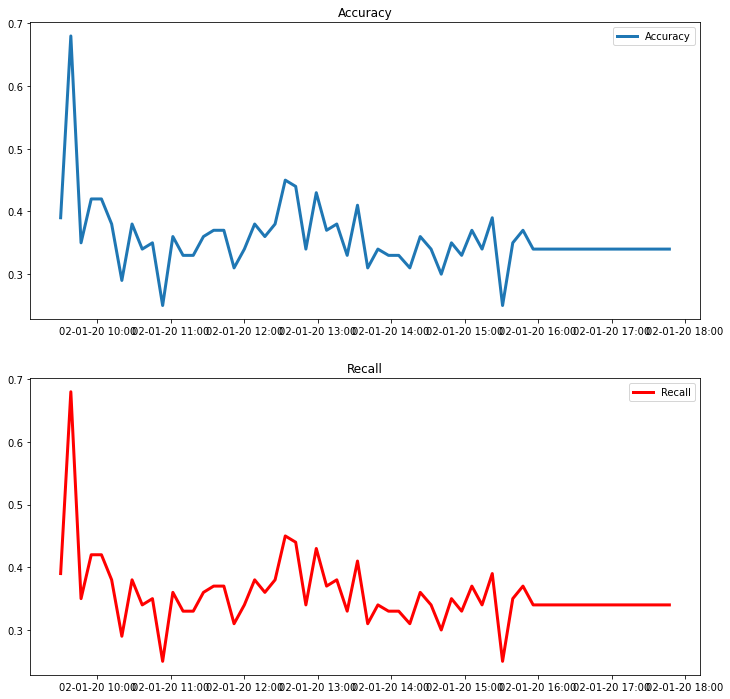

In [22]:
fig,axis=plt.subplots(2,1,figsize=(12,12))
axis[0].plot(dts,accuracy,lw=3,label='Accuracy')
axis[0].set_title('Accuracy')
axis[1].plot(dts,recall,lw=3,label='Recall',color='red')
axis[1].set_title('Recall')
axis[0].legend()
axis[1].legend()
xfmt = DateFormatter('%d-%m-%y %H:%M')
axis[0].xaxis.set_major_formatter(xfmt)
axis[1].xaxis.set_major_formatter(xfmt)

### Analysis across Jan 3, 2020

In [23]:
labelled_data=pd.read_csv(path+'data/labeled_data_2020-01-03.csv',index_col=0)

In [24]:
features=labelled_data[['FB0','FA0','FB2','FA2']]
outcomes=labelled_data['outcome']

features

,FB0,FA0,FB2,FA2
last_interval,,,,
2020-01-03 09:30:00,10.0,20.0,9.0,19.0
2020-01-03 09:30:05,61.0,1.0,-19.0,-2.0
2020-01-03 09:30:10,5.0,11.0,0.0,1.0
2020-01-03 09:30:15,2.0,42.0,0.0,-1.0
2020-01-03 09:30:20,5.0,1.0,0.0,0.0
...,...,...,...,...
2020-01-03 15:59:35,2.0,6.0,0.0,1.0
2020-01-03 15:59:40,3.0,4.0,1.0,3.0
2020-01-03 15:59:45,1.0,1.0,0.0,-2.0


In [25]:
batch_size=100

batch_data=batch_features(features,outcomes,batch_size)
batch_data

{0.0: {'last_interval': '2020-01-03 09:30:00',
  'features':                       FB0   FA0   FB2   FA2
  last_interval                              
  2020-01-03 09:30:00  10.0  20.0   9.0  19.0
  2020-01-03 09:30:05  61.0   1.0 -19.0  -2.0
  2020-01-03 09:30:10   5.0  11.0   0.0   1.0
  2020-01-03 09:30:15   2.0  42.0   0.0  -1.0
  2020-01-03 09:30:20   5.0   1.0   0.0   0.0
  ...                   ...   ...   ...   ...
  2020-01-03 09:37:55   4.0   2.0   2.0   1.0
  2020-01-03 09:38:00   3.0   1.0   0.0  -1.0
  2020-01-03 09:38:05   2.0   3.0   1.0   0.0
  2020-01-03 09:38:10   1.0   1.0  -1.0 -23.0
  2020-01-03 09:38:15   1.0   1.0  -1.0   0.0
  
  [100 rows x 4 columns],
  'outcomes': last_interval
  2020-01-03 09:30:00   -1
  2020-01-03 09:30:05    0
  2020-01-03 09:30:10    1
  2020-01-03 09:30:15    1
  2020-01-03 09:30:20    1
                        ..
  2020-01-03 09:37:55   -1
  2020-01-03 09:38:00    1
  2020-01-03 09:38:05   -1
  2020-01-03 09:38:10    0
  2020-01-03 09:

In [26]:
batched_estimates=batch_solve_mkl(features,outcomes,5,batch_size,'gaussian',5,verbose=False)

Batch  0 Last Interval 2020-01-03 09:30:00 complete with weights  [0.         0.22593546 0.24665106 0.25962185 0.26779163]
Batch  100 Last Interval 2020-01-03 09:38:20 complete with weights  [0.         0.22350237 0.23764547 0.25841361 0.28043855]
Batch  200 Last Interval 2020-01-03 09:46:40 complete with weights  [0.         0.21536492 0.24303719 0.26348655 0.27811134]
Batch  300 Last Interval 2020-01-03 09:55:00 complete with weights  [0.         0.24215562 0.24819103 0.25187206 0.2577813 ]
Batch  400 Last Interval 2020-01-03 10:03:20 complete with weights  [0.19227614 0.19523561 0.19981305 0.20425772 0.20841748]
Batch  500 Last Interval 2020-01-03 10:11:40 complete with weights  [0.         0.23120387 0.24558556 0.25654078 0.26666979]
Batch  600 Last Interval 2020-01-03 10:20:00 complete with weights  [0.         0.25389545 0.25332405 0.24794746 0.24483304]
Batch  700 Last Interval 2020-01-03 10:28:20 complete with weights  [0.         0.23082213 0.24649447 0.25719129 0.26549211]
Ba

In [27]:
batch_svm,batch_index=train_svm_batch(batch_data,batched_estimates,'gaussian',5)

In [28]:
evaluation_dict=predict_svm_batch(batch_svm,batch_index,batch_data,batched_estimates,'gaussian',5)

In [29]:
evaluation_dict

{'2020-01-03 09:30:00': {'accuracy': 0.38, 'recall': 0.38},
 '2020-01-03 09:38:20': {'accuracy': 0.61, 'recall': 0.61},
 '2020-01-03 09:46:40': {'accuracy': 0.34, 'recall': 0.34},
 '2020-01-03 09:55:00': {'accuracy': 0.39, 'recall': 0.39},
 '2020-01-03 10:03:20': {'accuracy': 0.34, 'recall': 0.34},
 '2020-01-03 10:11:40': {'accuracy': 0.37, 'recall': 0.37},
 '2020-01-03 10:20:00': {'accuracy': 0.29, 'recall': 0.29},
 '2020-01-03 10:28:20': {'accuracy': 0.29, 'recall': 0.29},
 '2020-01-03 10:36:40': {'accuracy': 0.31, 'recall': 0.31},
 '2020-01-03 10:45:00': {'accuracy': 0.33, 'recall': 0.33},
 '2020-01-03 10:53:20': {'accuracy': 0.33, 'recall': 0.33},
 '2020-01-03 11:01:40': {'accuracy': 0.34, 'recall': 0.34},
 '2020-01-03 11:10:00': {'accuracy': 0.35, 'recall': 0.35},
 '2020-01-03 11:18:20': {'accuracy': 0.32, 'recall': 0.32},
 '2020-01-03 11:26:40': {'accuracy': 0.36, 'recall': 0.36},
 '2020-01-03 11:35:05': {'accuracy': 0.41, 'recall': 0.41},
 '2020-01-03 11:43:25': {'accuracy': 0.3

In [30]:
dts=pd.to_datetime([i for i in evaluation_dict.keys()])
accuracy=np.array([i['accuracy'] for i in evaluation_dict.values()])
recall=np.array([i['recall'] for i in evaluation_dict.values()])

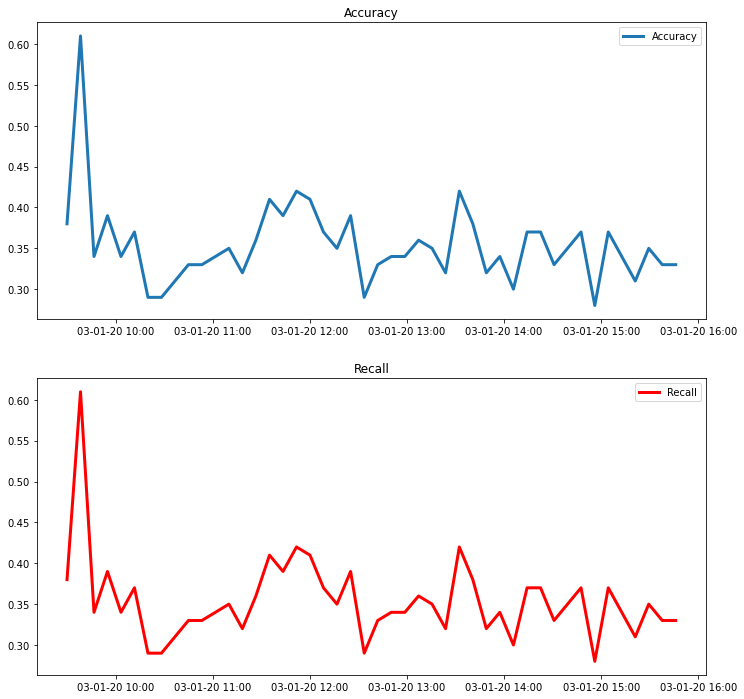

In [31]:
fig,axis=plt.subplots(2,1,figsize=(12,12))
axis[0].plot(dts,accuracy,lw=3,label='Accuracy')
axis[0].set_title('Accuracy')
axis[1].plot(dts,recall,lw=3,label='Recall',color='red')
axis[1].set_title('Recall')
axis[0].legend()
axis[1].legend()
xfmt = DateFormatter('%d-%m-%y %H:%M')
axis[0].xaxis.set_major_formatter(xfmt)
axis[1].xaxis.set_major_formatter(xfmt)

### Analysis across all of January 2020